# Snow Cover Extent bias LS3MIP IPSL
conda env: `phd_v3` (in `envs/phd`)

Try to compare the **snow cover** for the **CMIP6 historical** experiments: **coupled** + **land-hist**
- Zone: **NH** (try to see other mountainous areas)
- Period: **1979-2014**
- Model: **IPSL-CMA6-LR**
- Observation: **NOAA Climate Data Record (CDR)** of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756 (satellite)

Created: 16/09/2020 - Last modified: 16/09/2020

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1979','2014')
seasons = ['Annual', 'DJF', 'JJA']

var = 'snc'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Snow Cover Extent'

## Load models

In [3]:
# list_models = u.get_model_names()
list_models = ['IPSL-CM6A-LR']

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    print(institute, grid, realization, calendar)

IPSL-CM6A-LR (1/1)
IPSL gr r1i1p1f1 gregorian


In [4]:
def check_snc(da):
    # Some models have values between 0 and 1 even if units in %    
    if da.max().values <= 1.1:
        with xr.set_options(keep_attrs=True):
            da = da*100
        da.attrs['units'] = '%'

    # Some models have wrong values (+-0.1 for numeric precision)
    da = da.where( (da >= -0.1) & (da <= 100.1) )

In [5]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1})

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_historical.time.size)
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_land_hist.time.size)

# snc (0-1 to % when needed and take out wrong values)
check_snc(da_historical)
check_snc(da_land_hist)

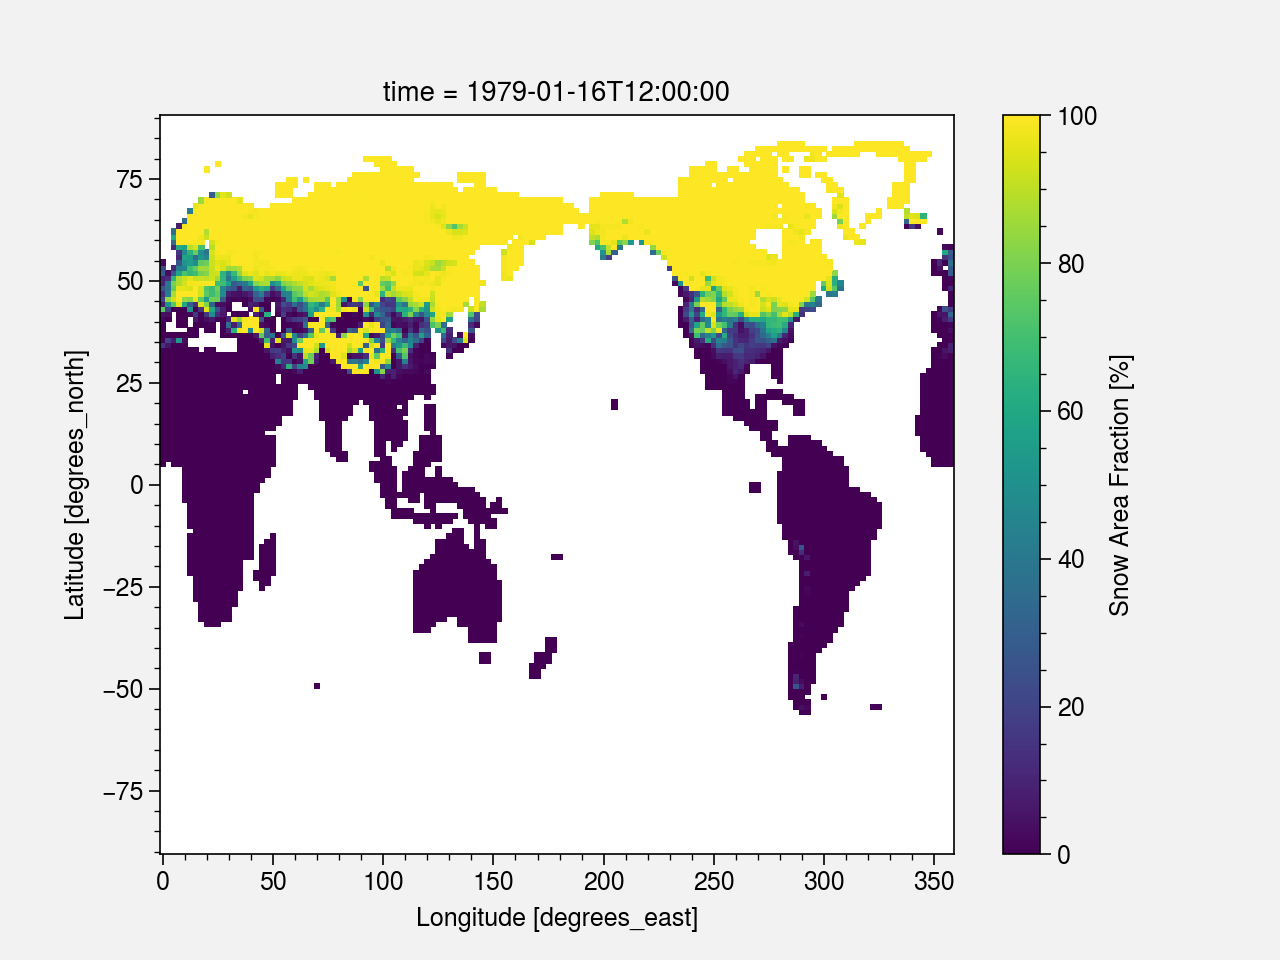

In [6]:
da_historical.isel(time=0).plot()

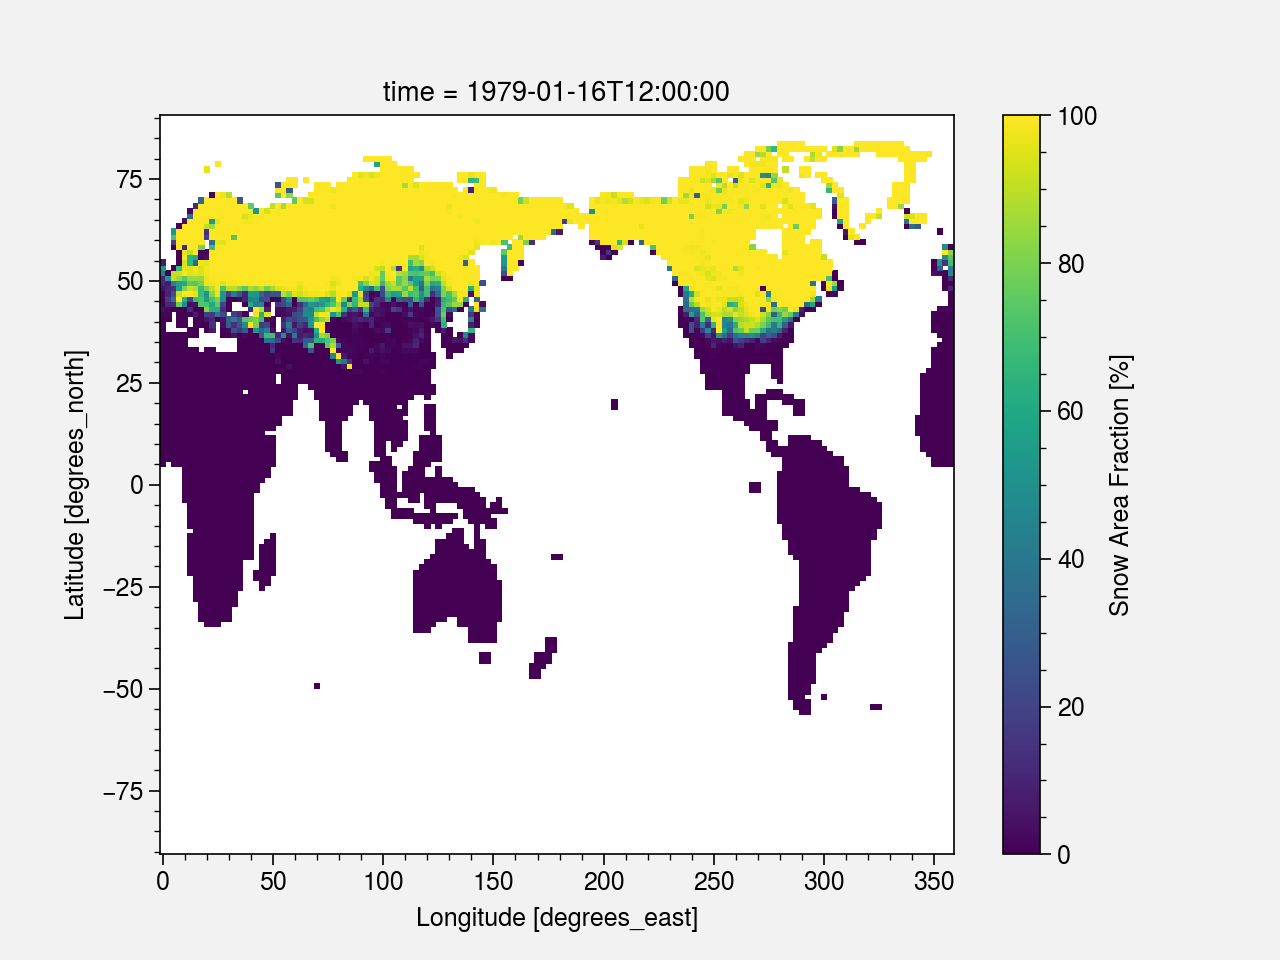

In [7]:
da_land_hist.isel(time=0).plot()

## Load observation
NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1:
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756 (satellite)

*The data record for the **NH** SCE CDR spans from October 4, **1966 to present**. Prior to June 1999 the NH SCE CDR is based on satellite-derived maps of NH SCE produced **weekly** by trained NOAA meteorologists. Early NH SCE maps were based on a visual interpretation of photographic copies of shortwave imagery. Analysts incorporated various sources of imagery into the SCE mapping process as they became available (e.g. AVHRR, VAS). In June 1999 NOAA NH SCE maps were replaced by SCE output from the Interactive Multisensor Snow and Ice Mapping System (IMS) at the National Ice Center (NIC). SCE output from the NIC IMS is processed at Rutgers University and appended to the NH SCE CDR to form a cohesive, long-term climate record of SCE.*

Other observations: https://globalcryospherewatch.org/reference/snow_inventory.php

In [8]:
raw_obs_ds = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)
# raw_obs_ds

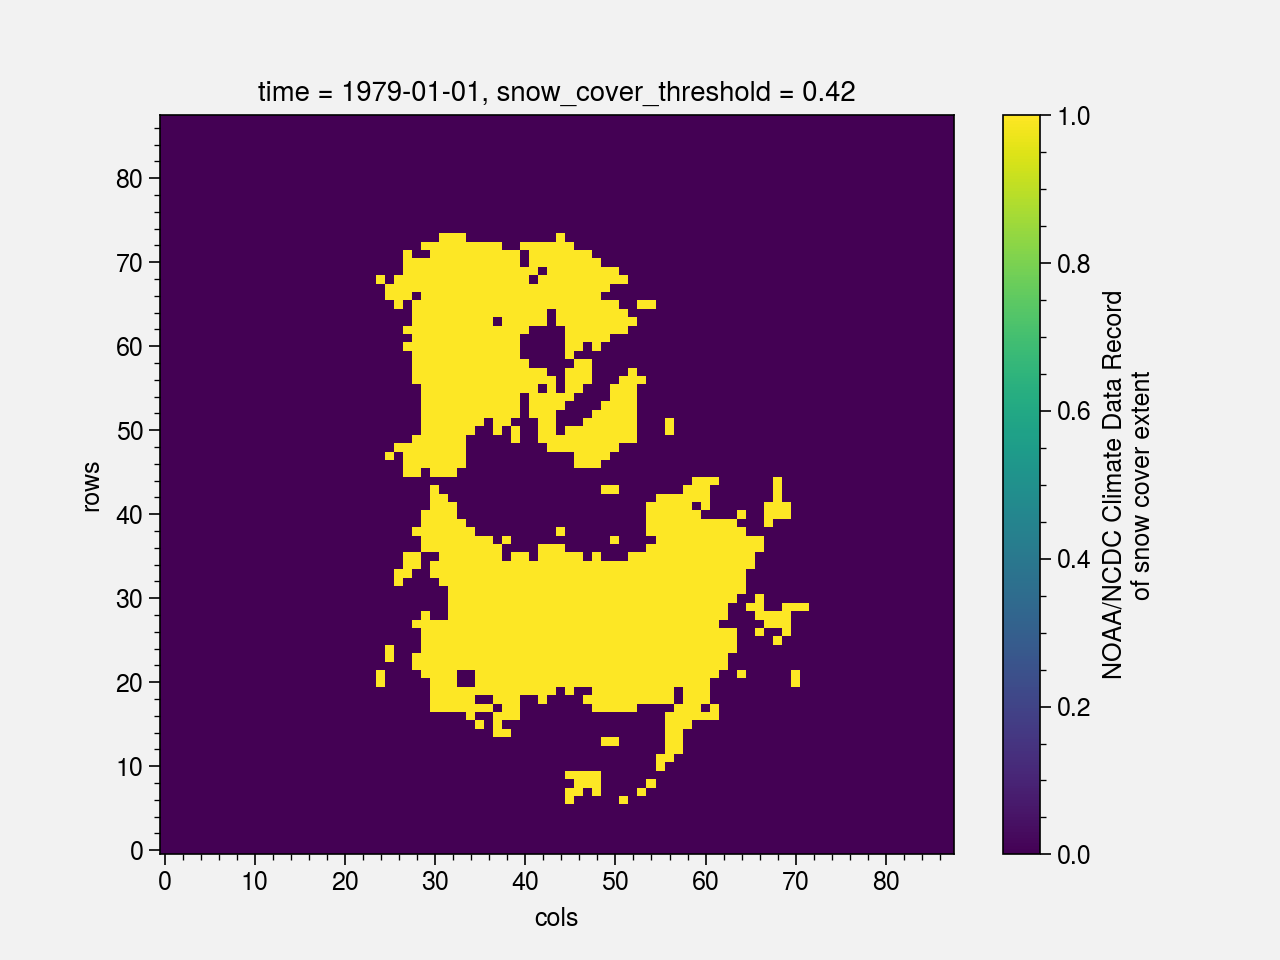

In [9]:
raw_obs_ds.isel(time=0).snow_cover_extent.plot()

### Convert weekly to monthly SCE (units %)

In [10]:
# Get the snc variable, keep only land data and convert to %
obs = raw_obs_ds.snow_cover_extent.where(raw_obs_ds.land == 1)*100  
obs.attrs['units'] = '%'
obs.attrs['long_name'] = raw_obs_ds.snow_cover_extent.long_name
obs.attrs['short_name'] = 'NOAA/NCDC CDR'
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'}) # Rename lon and lat for the regrid

# Resamble data per month (from per week)
obs = obs.resample(time='M').mean('time', skipna=False, keep_attrs=True)

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


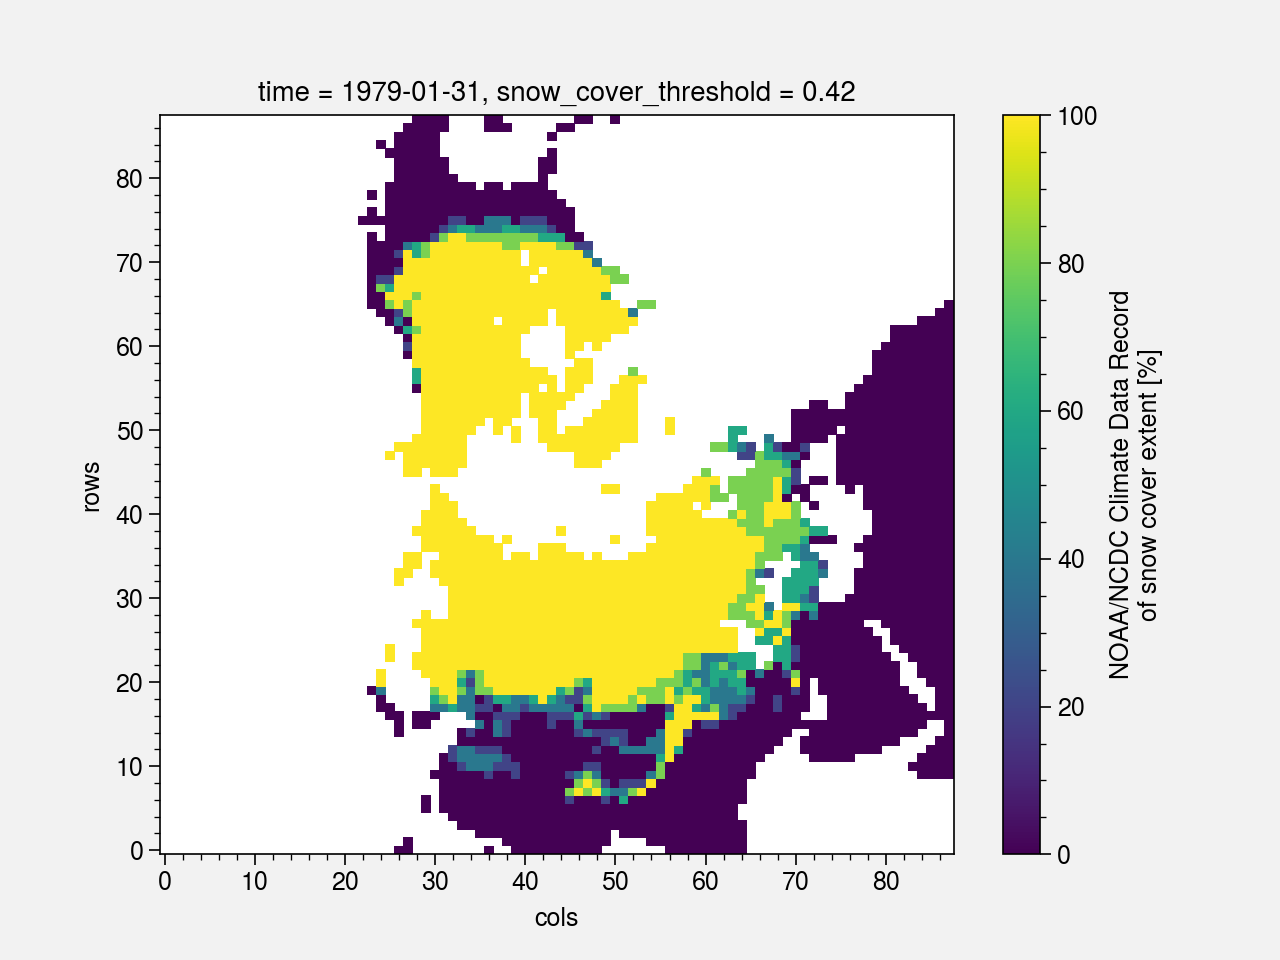

In [11]:
obs.isel(time=0).plot()

## Regrid observation to the model grid
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [12]:
# To put NaNs instead of 0 where there is no data (https://github.com/JiaweiZhuang/xESMF/issues/15)
import scipy
def add_matrix_NaNs(regridder):
        X = regridder.weights
        M = scipy.sparse.csr_matrix(X)
        num_nonzeros = np.diff(M.indptr)
        M[num_nonzeros == 0, 0] = np.NaN
        regridder.weights = scipy.sparse.coo_matrix(M)
        return regridder


regridder = xe.Regridder(obs, da_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder = add_matrix_NaNs(regridder)
obs_regrid = regridder(obs)

Reuse existing file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


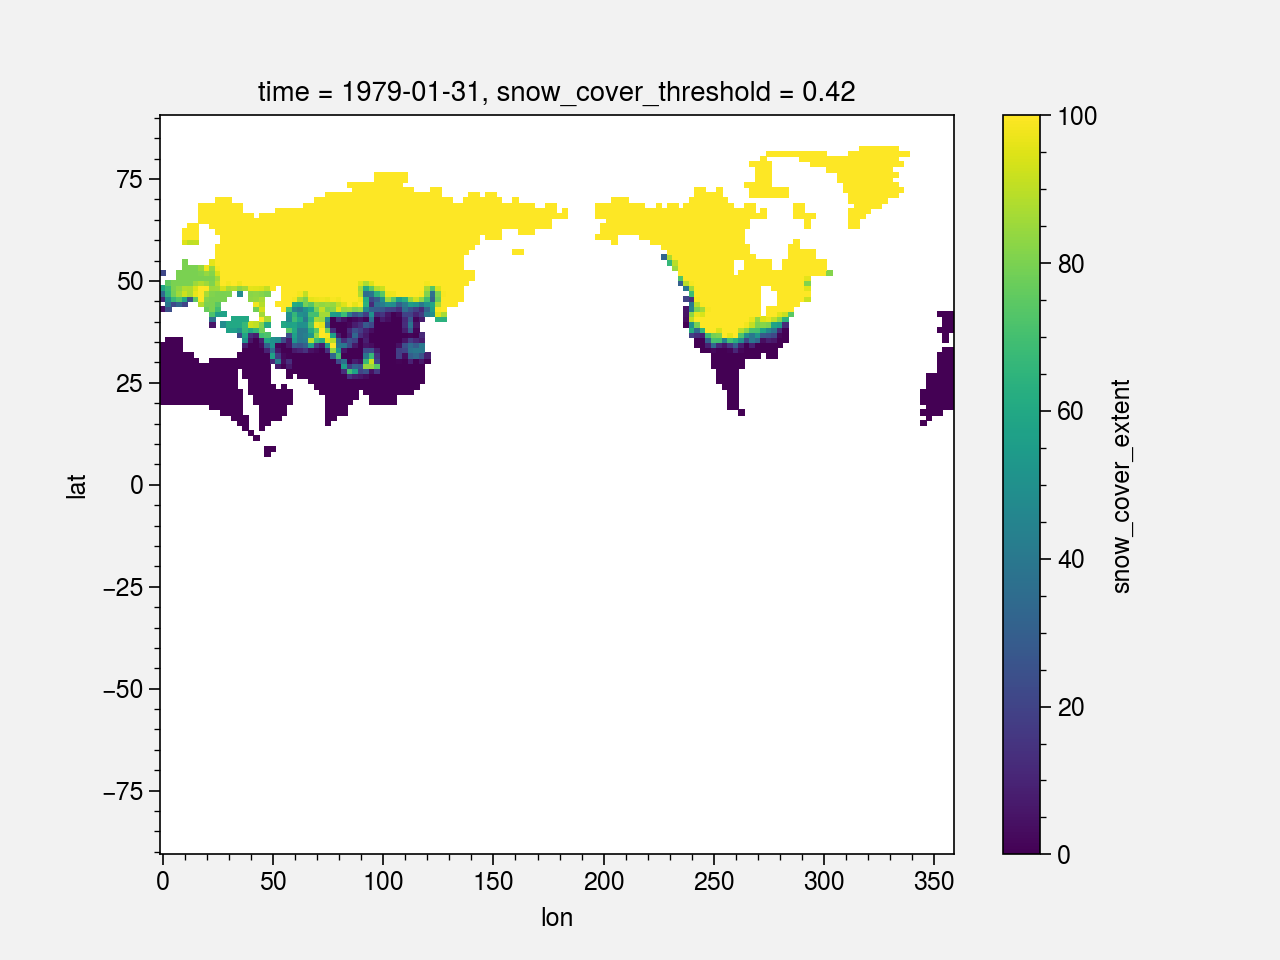

In [13]:
obs_regrid.isel(time=0).plot()

## Compare plots

### First time step

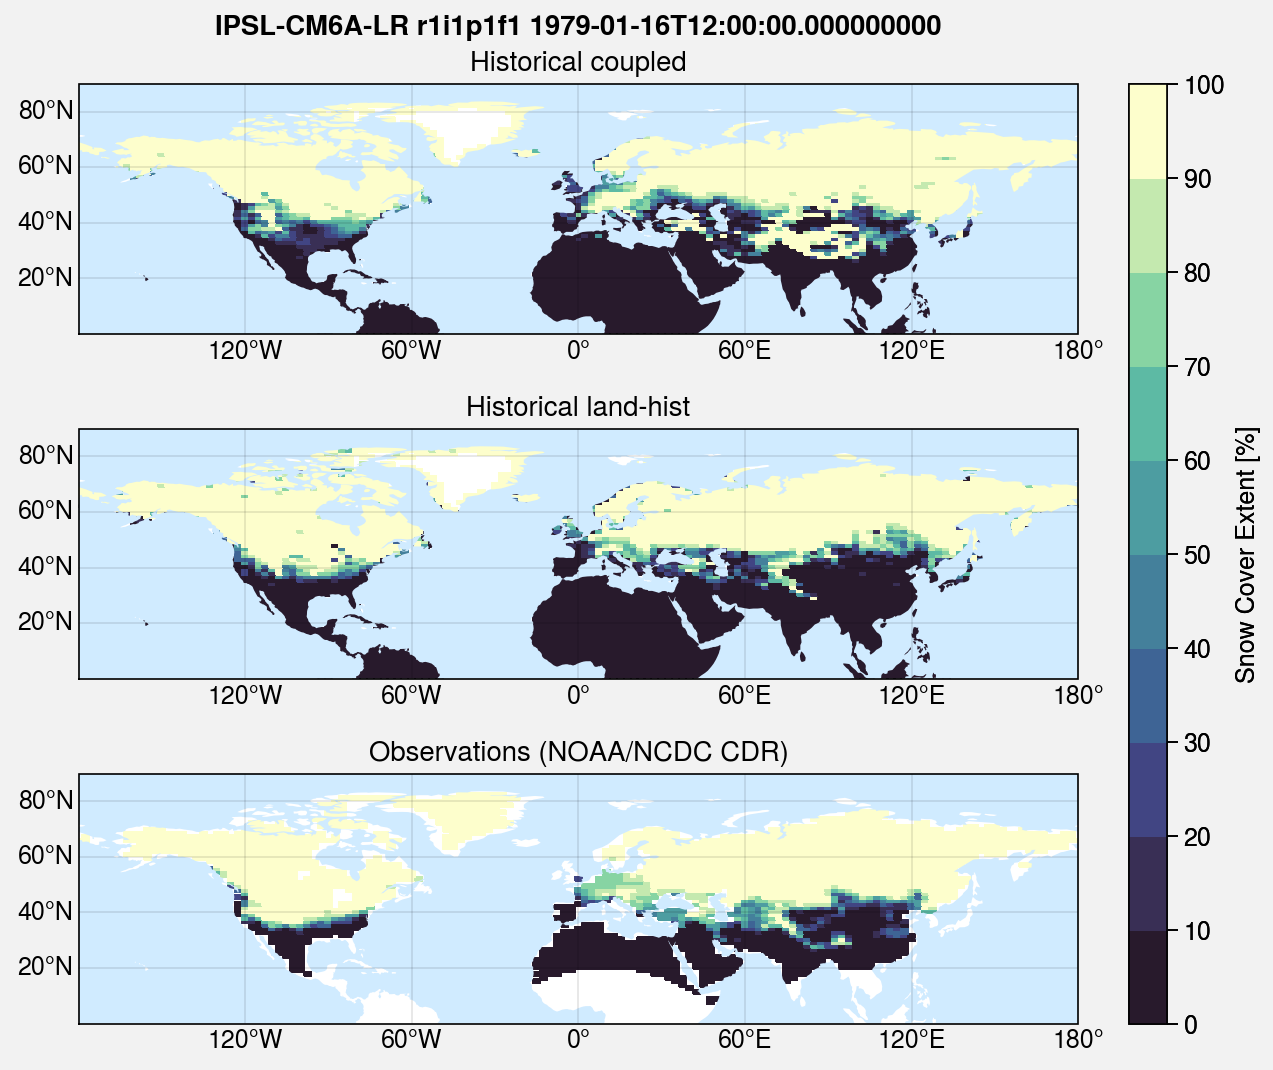

In [22]:
fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

cmap='deep_r'
levels=plot.arange(0,100,10)
itime=0

axs.format(
    labels=True,
    latlim=(0,90),
    ocean=True, oceancolor='blue1',
    coast=False,
    suptitle=model+' '+realization+' '+str(da_historical.isel(time=itime).time.values)
)

axs[0].pcolormesh(da_historical.isel(time=itime), cmap=cmap, levels=levels)
axs[0].format(title='Historical coupled')

axs[1].pcolormesh(da_land_hist.isel(time=itime), cmap=cmap, levels=levels)
axs[1].format(title='Historical land-hist')

m = axs[2].pcolormesh(obs_regrid.isel(time=itime), cmap=cmap, levels=levels)
axs[2].format(title='Observations ('+obs.short_name+')')

fig.colorbar(m, label=label+' ['+units+']')

### Climatology

In [15]:
clim_historical = [None]*len(seasons)
clim_land_hist = [None]*len(seasons)
clim_obs_regrid = [None]*len(seasons)

for i, season in enumerate(seasons):
    clim_historical[i] = u.clim(da_historical, season=season, calendar=calendar)
    clim_land_hist[i] = u.clim(da_land_hist, season=season, calendar=calendar)
    clim_obs_regrid[i] = u.clim(obs_regrid, season=season, calendar=calendar)

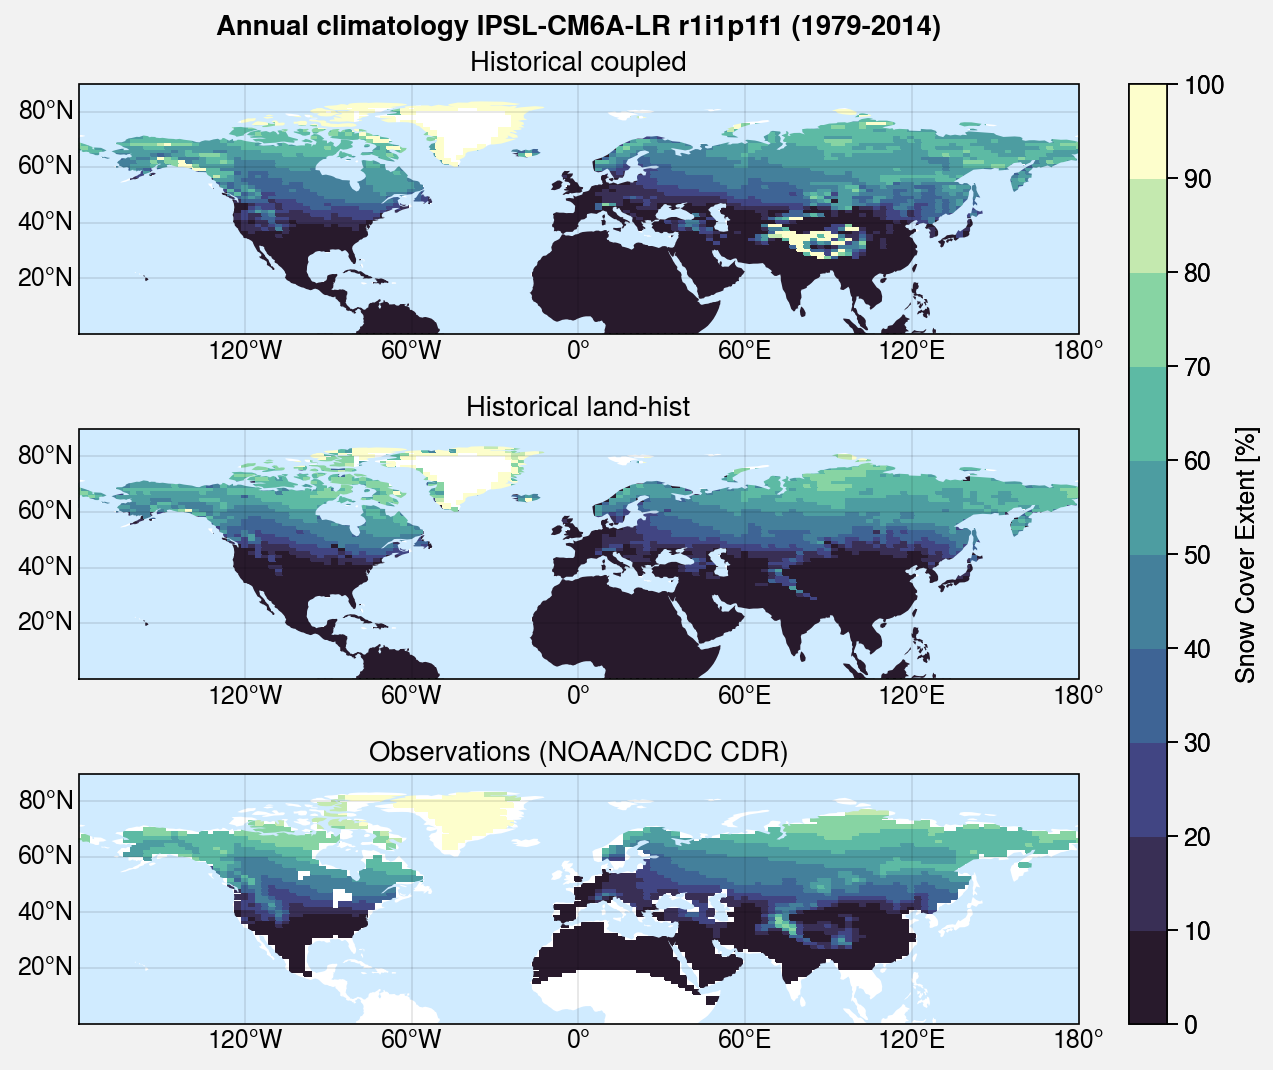

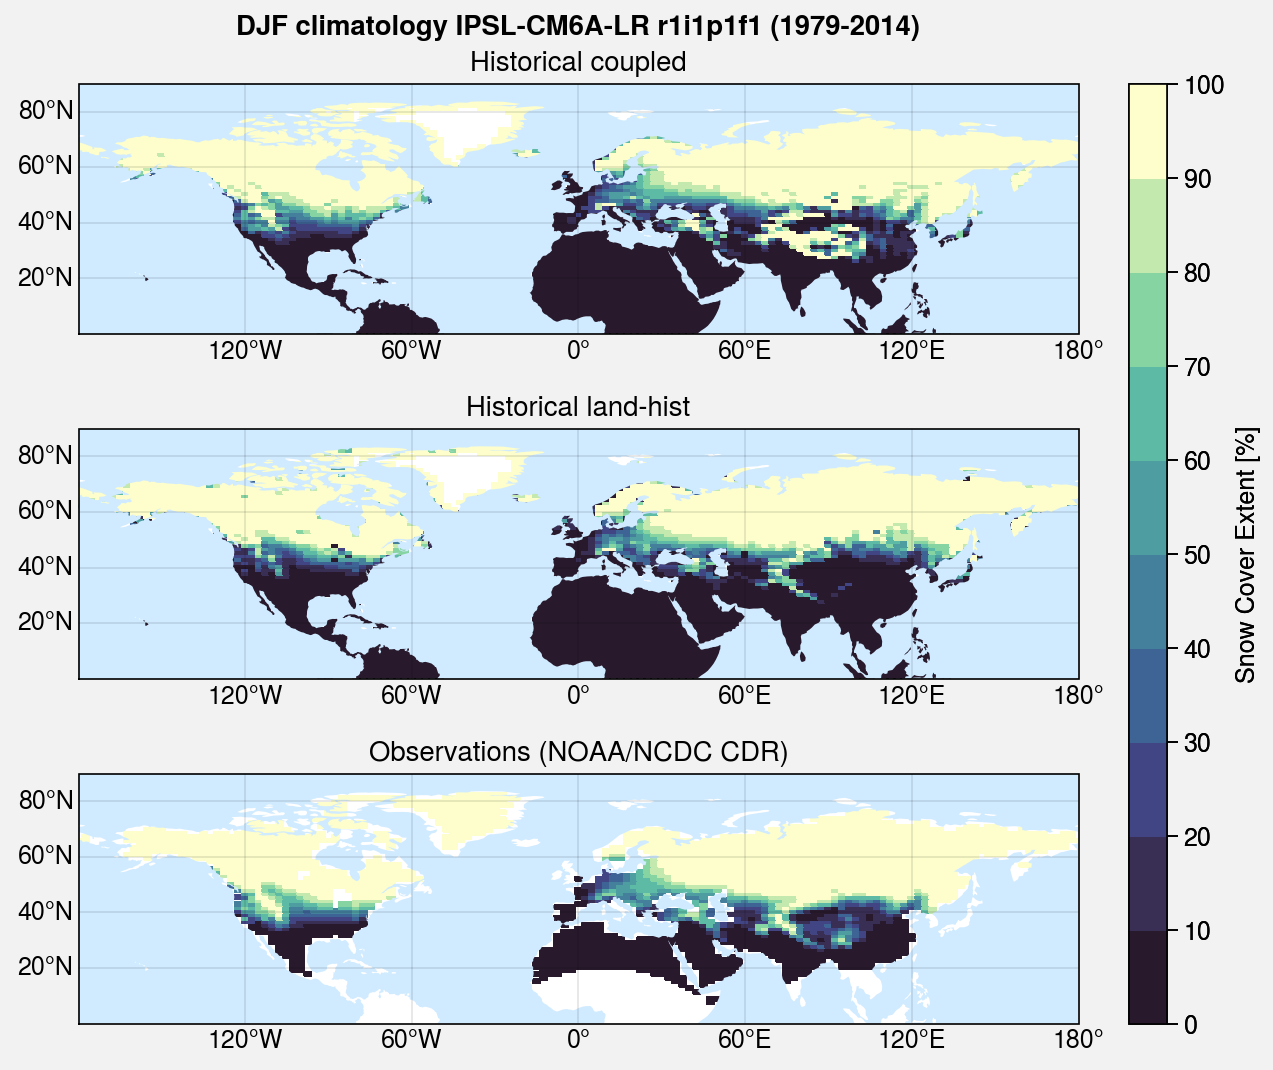

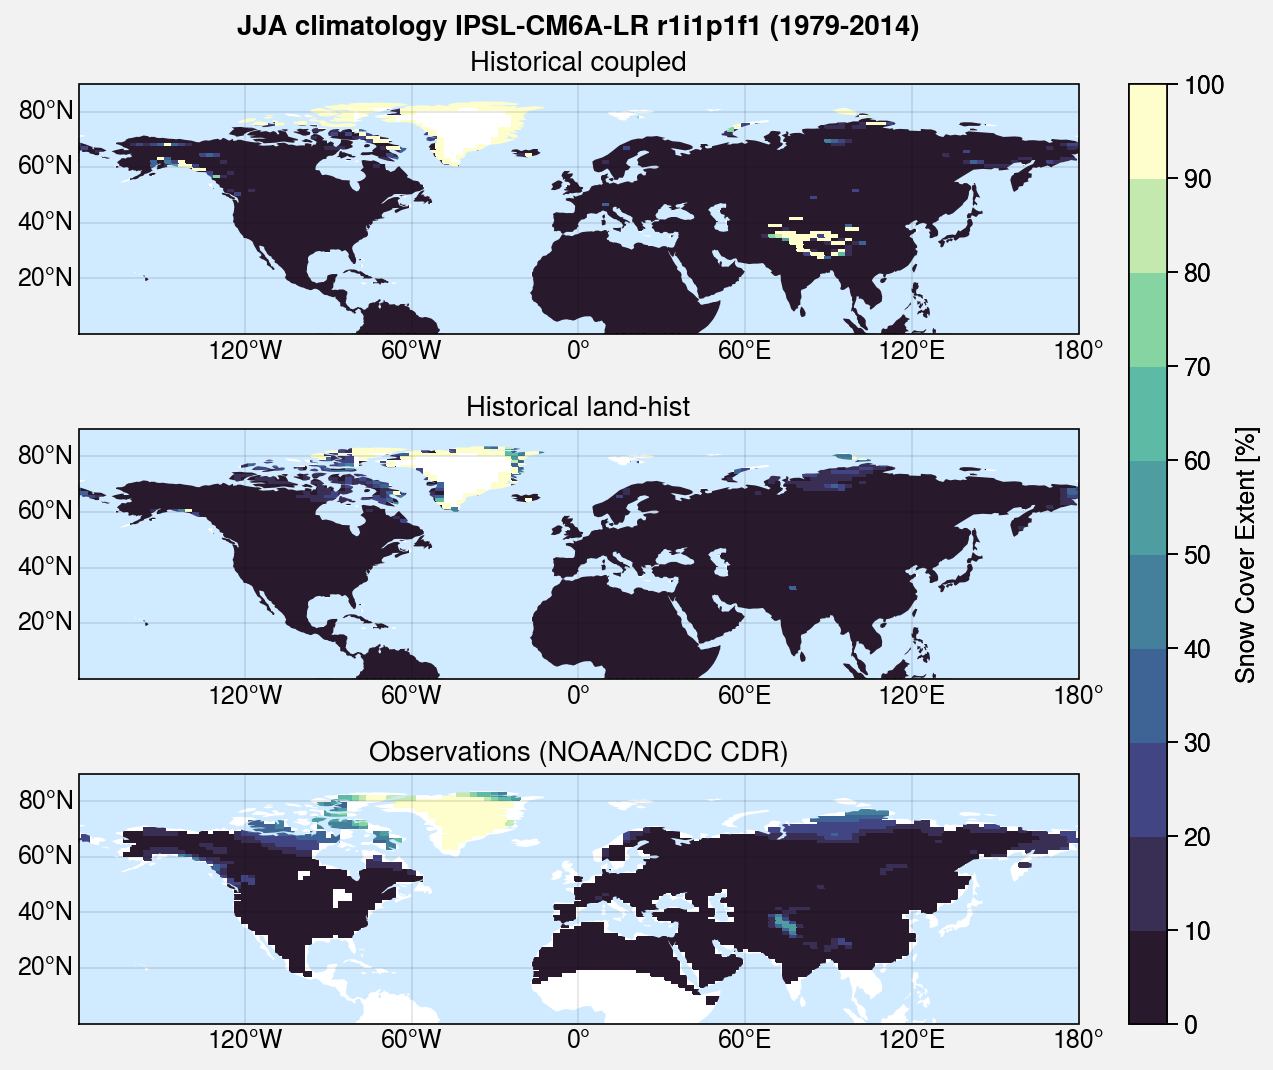

In [23]:
for i, season in enumerate(seasons):    
    fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

    cmap='deep_r'
    levels=plot.arange(0,100,10)

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='blue1',
        coast=False,
        suptitle=season+' climatology '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(clim_historical[i], cmap=cmap, levels=levels)
    axs[0].format(title='Historical coupled')

    axs[1].pcolormesh(clim_land_hist[i], cmap=cmap, levels=levels)
    axs[1].format(title='Historical land-hist')

    m = axs[2].pcolormesh(clim_obs_regrid[i], cmap=cmap, levels=levels)
    axs[2].format(title='Observations ('+obs.short_name+')')

    fig.colorbar(m, label=label+' ['+units+']')
    
    filename = season+'_clim_CDR_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')

## Bias

In [24]:
bias_historical = [None]*len(seasons)
bias_land_hist = [None]*len(seasons)

for i, season in enumerate(seasons):
    bias_historical[i] = clim_historical[i] - clim_obs_regrid[i]
    bias_land_hist[i] = clim_land_hist[i] - clim_obs_regrid[i]

In [25]:
for i, season in enumerate(seasons):
    print(xr.ufuncs.fabs(bias_historical[i]).max().values, xr.ufuncs.fabs(bias_land_hist[i]).max().values)

90.87808726608326 62.69901871129139
84.23401838383305 84.81390832350104
99.8919233225392 87.49099554273543


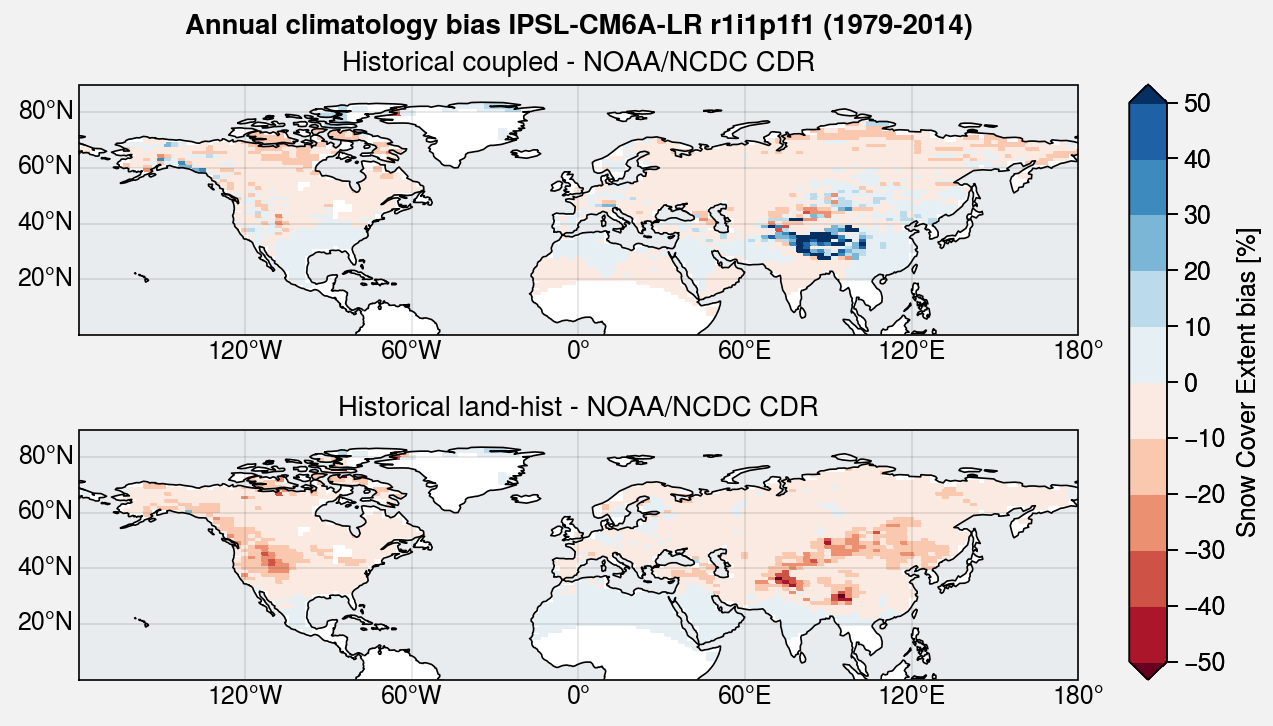

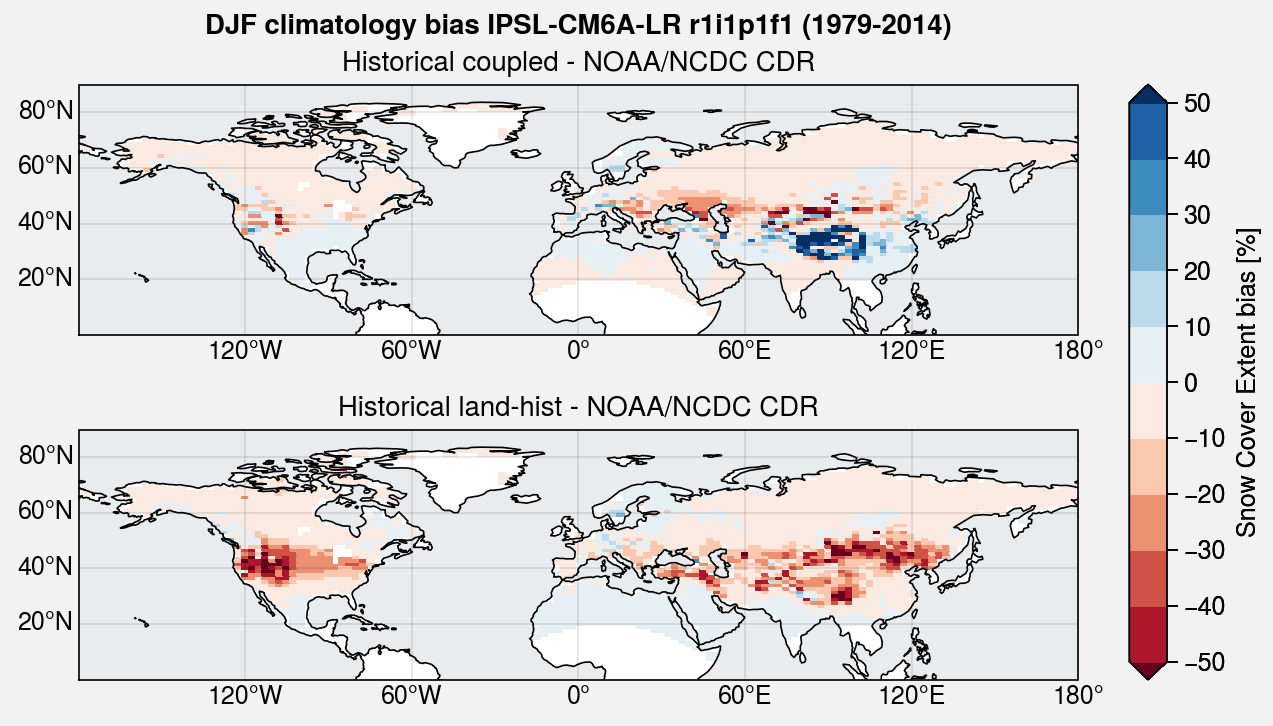

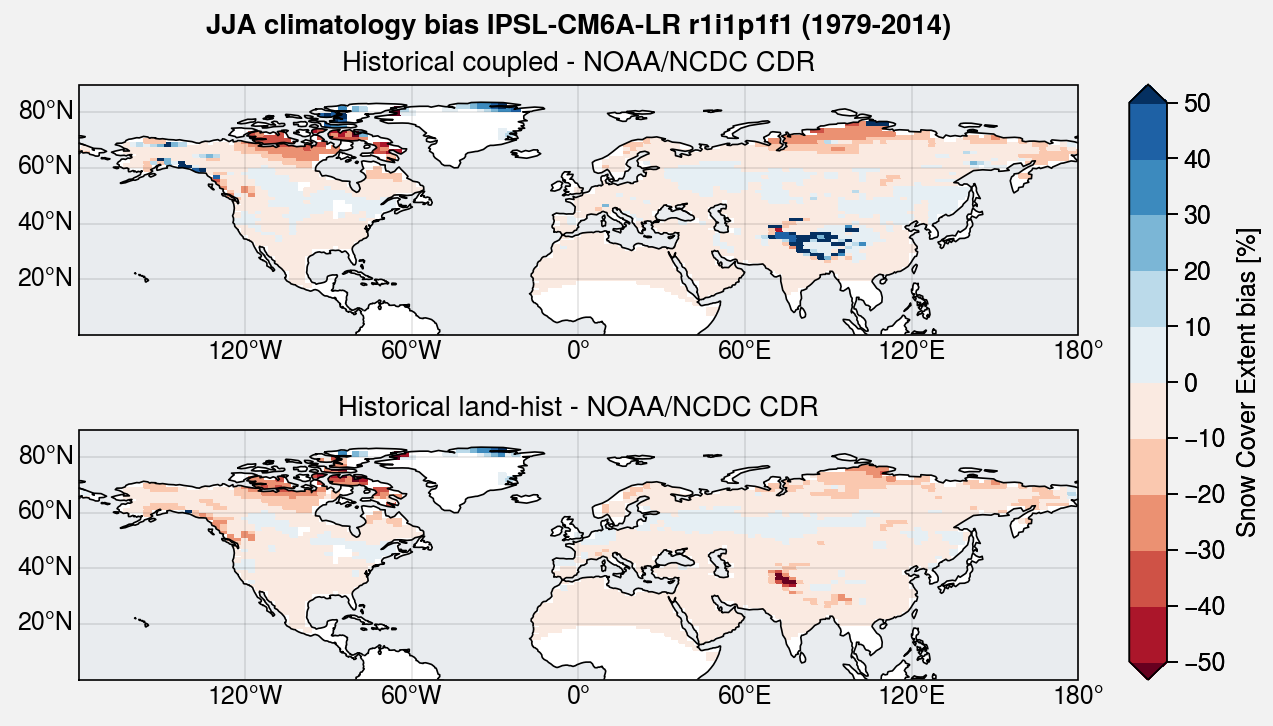

In [26]:
for i, season in enumerate(seasons):   
# for i, season in enumerate(['Annual']):   
    fig, axs = plot.subplots(nrows=2, ncols=1, proj='cyl', axwidth=5)

    cmap='NegPos_r'
    cmap='RdBu'
    levels=plot.arange(-50,50,10)
    extend='both'

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='gray2',
        coast=True, borders=False,
        suptitle=season+' climatology bias '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(bias_historical[i], cmap=cmap, levels=levels, extend=extend)
    axs[0].format(title='Historical coupled - '+obs.short_name)

    m = axs[1].pcolormesh(bias_land_hist[i], cmap=cmap, levels=levels, extend=extend)
    axs[1].format(title='Historical land-hist - '+obs.short_name)

    fig.colorbar(m, label=label+' bias ['+units+']')

    filename = season+'_bias_CDR_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')